In [152]:
import pyiron
from pyiron import Project
from pyiron_base import GenericJob
from pyiron_workflow import Workflow
from PIL import Image
import matplotlib.pylab as plt
import numpy as np
import os
import shutil
import base64
import io
import pylnk3
import re
import subprocess

In [153]:
class AbaqusScriptJob(GenericJob):
    
    ### Define a new class that inherits from GenericJob to run Abaqus scripts
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.executable  = r"C:\SIMULIA\Commands\abq2018.bat"   # Abaqus Actuator Path
        self.script_path = None   # User-set Python script path (for noGUI mode operation)
    
    def write_input(self):
        if self.script_path is None:
            raise ValueError("please set python script path for abaqus")

        ## Copy the script to the working directory
        self.input_script = os.path.basename(self.script_path)   # Script name only (no path)
        local_input_script = os.path.join(self.working_directory, self.input_script)   # Spell out the target path in the working directory
        shutil.copy(self.script_path, local_input_script)   # Copy the script to the working directory

    def run_in_abaqus(self):
        ## Construct and run Abaqus on the command line
        cmd = f'"{self.executable}" cae noGUI={self.script_path}'
        subprocess.check_call(cmd, cwd=self.working_directory, shell=True)   ## Run the command in the working directory

    run_static = run_in_abaqus
    
    def collect_output(self):
        wd = self.working_directory
        cae_files = [f for f in os.listdir(wd) if f.lower().endswith('.cae')]
        inp_files = [f for f in os.listdir(wd) if f.lower().endswith('.inp')]
            
        if cae_files and inp_files:
            self['user/cae_path'] = os.path.join(wd, cae_files[0])
            self['user/inp_path'] = os.path.join(wd, inp_files[0]) 
        ## Since it is a job object, saved in HDF5, it can be called directly without return

In [169]:
class InpProcessingJob(GenericJob):

    ### Define a new class that inherits from GenericJob to run Abaqus scripts
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.executable  = r"python"    # Python executes scripts by default
        self.script_path = None    # Python script for .inp processing
        self.inp_path    = None    # Path to the .inp file to be processed

    def write_input(self):
        if not self.script_path or not self.inp_path:
            raise ValueError("please set python script path and .inp file path")
            
        ## Extract the file name and copy it to the current project directory.
        # copy python script
        input_script = os.path.basename(self.script_path)
        local_subprocess_script = os.path.join(self.working_directory, input_script)
        shutil.copy(self.script_path, local_subprocess_script)
        self.script_path = local_subprocess_script

        # copy .inp file
        inp_path = os.path.basename(self.inp_path)
        local_inp_path = os.path.join(self.working_directory, inp_path)
        shutil.copy(self.inp_path, local_inp_path)
        self.inp_path = local_inp_path

    def run_static(self):
        ## Constructor commands: python script Input file
        cmd = [str(self.executable), self.script_path, self.inp_path]
        subprocess.check_call(cmd, cwd=self.working_directory)

    def collect_output(self):
        wd = self.working_directory
        all_txt_files = [f for f in os.listdir(wd) if f.lower().endswith(".txt")]
        all_txt_files_path = [os.path.abspath(os.path.join(wd, f)) for f in os.listdir(wd) if f.endswith(".txt")]
        print(f"finish, all files：{all_txt_files}\n")

        self["user/all_txt_files"] = all_txt_files_path
        
        return {"txt_paths": all_txt_files_path} 

In [155]:
class TxtPlotJob(GenericJob):

    ### Define a new class that inherits from GenericJob to run Abaqus scripts
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.executable  = r"python"
        self.script_path = None    # txt processing script
        self.input_txt_data = []    # # List of txt files to be processed

    def write_input(self):
        if not self.script_path or not self.input_txt_data:
            raise ValueError("please set python script path and txt data path")

        # Extract the file name and copy it to the current project directory.
        # copy python script
        self.input_script = os.path.basename(self.script_path)
        local_subprocess_script = os.path.join(self.working_directory, self.input_script)
        shutil.copy(self.script_path, local_subprocess_script)

        # copy all txt
        self.local_txts = []
        for txt in self.input_txt_data:
            txt_name = os.path.basename(txt)
            shutil.copy(txt, os.path.join(self.working_directory, txt_name))
            self.local_txts.append(txt_name)

    def run_static(self):
        ## Constructor commands: python script Input file
        cmd = [str(self.executable), self.script_path] + self.local_txts
        subprocess.check_call(cmd, cwd=self.working_directory)
        print(f"finish, all files: [Plot generated]\n")

    def collect_output(self):
        wd = self.working_directory
        image_files = [f for f in os.listdir(wd) if f.lower().endswith('.png')]
                
        if "output_images" in self.project_hdf5.list_groups():
            del self.project_hdf5["output_images"]

        for img in image_files:
            full_path = os.path.join(wd, img)
    
            # base64
            with open(full_path, 'rb') as f:
                img_data = f.read()
                img_base64 = base64.b64encode(img_data).decode('utf-8')
                self.project_hdf5[f"output_images/{img}"] = img_base64
    
            # 
            img_pil = Image.open(io.BytesIO(base64.b64decode(img_base64)))
            plt.figure(figsize=(10, 6))
            plt.imshow(img_pil)
            plt.title(img)
            plt.axis('off')
            plt.show()
            
        image_path = [os.path.join(wd, f) for f in image_files]
        txt_path = [os.path.join(wd, f) for f in self.local_txts]

        self["user/image_paths"] = image_path
        self["user/txt_paths"] = txt_path

        return {"image_paths": image_path,
                "txt_paths": txt_path}

In [163]:
class IntelCompiler(GenericJob):

    ### Define a new class that inherits from GenericJob to run Abaqus scripts
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.compiler_path = None    # Shortcut to .lnk for Intel compiler environment
        self.fortran_file = None    # Path to the .for file to compile
        self.output_exe = None    # Optional, user-specified output .exe filename

    def write_input(self):
        ## Parsing .lnk shortcuts (Windows)
        if not self.compiler_path or not self.fortran_file:
            raise ValueError("Please set compiler path and fortran file path")

        self.fortran_file = os.path.abspath(self.fortran_file)
        self.compiler_path = os.path.abspath(self.compiler_path)

        # Copy .for file to working directory
        self.local_fortran = os.path.join(self.working_directory, os.path.basename(self.fortran_file))
        shutil.copy(self.fortran_file, self.local_fortran)

    def run_static(self):
        ## Parsing .lnk shortcuts (Windows)
        with open(self.compiler_path, 'rb') as f:
            lnk = pylnk3.parse(f)

        raw_path = lnk.path.strip('"')    # Executable path to which the shortcut points
        raw_args = lnk.arguments.strip()    # Shortcut parameters

        ## If .lnk points to cmd.exe, it is necessary to extract the .bat path from the parameter
        if raw_path.lower().endswith("cmd.exe"):
            match = re.search(r'"(?P<bat>C:.*?\.bat)"\s*(?P<args>[^"]*)', raw_args, re.IGNORECASE)
            if not match:
                raise ValueError(f"Unable to extract .bat file path from .lnk arguments with contents：{raw_args}")
            env_bat_path = match.group("bat")
            extra_args = match.group("args")
        else:
            env_bat_path = raw_path
            extra_args = raw_args

        ## Constructing the ifort compilation command
        # exe_name = self.output_exe or os.path.splitext(os.path.basename(self.local_fortran))[0] + ".exe"
        # exe_name = os.path.normpath(exe_name)
        fortran_path = os.path.normpath(self.local_fortran)
        compile_cmd = f'ifort "{fortran_path}"'

        setup_cmd = f'call "{env_bat_path}" {extra_args} && {compile_cmd}'

        # print(setup_cmd)

        try:
            result = subprocess.run(
                f'cmd /c "{setup_cmd}"',
                cwd=self.working_directory,
                shell=True,
                check=True,
                text=True,
                capture_output=True
            )
            print("compiler output:\n", result.stdout)
            if result.stderr:
                print("warning:\n", result.stderr)
        except subprocess.CalledProcessError as e:
            print("error")
            print("stdout:\n", e.stdout)
            print("stderr:\n", e.stderr)
            raise
            
        # self.exe_path = os.path.normpath(os.path.join(self.working_directory, exe_name))
        # print(self.exe_path)

    def collect_output(self):
        wd = self.working_directory
        exe_files = [f for f in os.listdir(wd) if f.lower().endswith(".exe")]

        if not exe_files:
            raise FileNotFoundError(".exe file not found in the working directory")

        exe_filename = exe_files[0]
        exe_path = os.path.abspath(os.path.join(wd, exe_filename))

        self["user/exe_filename"] = exe_filename
        self["user/exe_path"] = exe_path
        
        print(f"Finish, generated file: ['{exe_filename}']\n")
        
        return {"exe_filename": exe_filename,
                "exe_path": exe_path}

In [164]:
class RunExeInCompiler(GenericJob):

    ### Define a new class that inherits from GenericJob to run Abaqus scripts
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.compiler_path = None    # Shortcut to .lnk for Intel compiler environment
        self.exe_path = None    # full path to .exe
        self.input_txt_files = []    # List of .txt input files needed to run with .exe
    
    def write_input(self):
        if not self.compiler_path or not self.exe_path:
            raise ValueError("Please set compiler path and .exe path")

        self.exe_path = os.path.abspath(self.exe_path)
        self.compiler_path = os.path.abspath(self.compiler_path)

        # print("RunExeInCompiler - exe_path:", self.exe_path)
        # print("RunExeInCompiler - input_txt_files:", self.input_txt_files)
        
        # Copy .exe to working directory
        self.exe_name = os.path.basename(self.exe_path)
        self.local_exe = os.path.join(self.working_directory, self.exe_name)
        shutil.copy(self.exe_path, self.local_exe)

        # Copy all input txt files into working directory
        self.local_txt_files = []
        for txt_path in self.input_txt_files:
            txt_name = os.path.basename(txt_path)
            dst_path = os.path.join(self.working_directory, txt_name)
            shutil.copy(txt_path, dst_path)
            self.local_txt_files.append(dst_path)
            
    def run_static(self):
        with open(self.compiler_path, 'rb') as f:
            lnk = pylnk3.parse(f)

        raw_path = lnk.path.strip('"')
        raw_args = lnk.arguments.strip()

        if raw_path.lower().endswith("cmd.exe"):
            match = re.search(r'"(?P<bat>C:.*?\.bat)"\s*(?P<args>[^"]*)', raw_args, re.IGNORECASE)
            if not match:
                raise ValueError(f"Unable to extract .bat file path from .lnk arguments with contents：{raw_args}")
            env_bat_path = match.group("bat")
            extra_args = match.group("args").strip('"')
        else:
            env_bat_path = raw_path
            extra_args = raw_args
            
        ## First call the compiler environment variable
        ## Then cd to the working directory
        ## Finally, execute the .exe file
        run_cmd = f'call "{env_bat_path}" {extra_args} && cd /d "{self.working_directory}" && "{self.exe_name}"'

        # print(f"\n{run_cmd}\n")

        try:
            result = subprocess.run(
                f'cmd /c "{run_cmd}"',
                cwd=self.working_directory,
                shell=True,
                check=True,
                capture_output=True,
                text=True
            )
            print(result.stdout)
            print(result.stderr)
            
        except subprocess.CalledProcessError as e:
            print("error：")
            print("STDOUT:\n", e.stdout)
            print("STDERR:\n", e.stderr)
            raise

    def collect_output(self):
        outputs = [f for f in os.listdir(self.working_directory) if f.endswith('.odb')]
        print(f"Finish, generated files: {outputs}\n")

        self["user/output_files"] = [os.path.join(self.working_directory, f) for f in outputs]
        self["user/input_txt_files"] = self.local_txt_files
        
        return {"output_files": [os.path.join(self.working_directory, f) for f in outputs]}

In [167]:
@Workflow.wrap.as_function_node("export_cae_inp")
def export_inp_cae(project_path, script_path):
    job = pr.create_job(AbaqusScriptJob, 'export_cae_inp')
    job.script_path = script_path
    job.run(delete_existing_job=True)

    wd = job.working_directory

    ## Wait for .cae and .inp files to be generated (blocking wait)
    while True:
        files = set(os.listdir(wd))
        cae = [f for f in files if f.lower().endswith('.cae')]
        inp = [f for f in files if f.lower().endswith('.inp')]
        if cae and inp:
            print(f"Finish, all files： {cae}, {inp}\n")
            break
        time.sleep(2)

    job.collect_output()

    return {"cae_path": job["user/cae_path"],
            "inp_path": job["user/inp_path"]}


@Workflow.wrap.as_function_node("process_inp_to_txt")
def process_inp(project_path, inp_path, script_path):
    job = pr.create_job(InpProcessingJob, 'process_inp')
    job.script_path = script_path
    job.inp_path = inp_path
    job.run(delete_existing_job=True)
    job.collect_output()

    txt_files = job["user/all_txt_files"]
    return txt_files  # List[str]


@Workflow.wrap.as_function_node("plot_txt")
def plot_txt_data(project_path, script_path, txt_files):
    job = pr.create_job(TxtPlotJob, 'plot_txt')
    job.script_path = script_path
    job.input_txt_data = txt_files
    job.run(delete_existing_job=True)
    output = job.collect_output()
    return output


@Workflow.wrap.as_function_node("compile_and_run_fortran")
def compile_and_run_fortran(project_path, compiler_path, fortran_path, exe_name=None):
    job = pr.create_job(IntelCompiler, "fortran_compile_job")
    job.compiler_path = compiler_path
    job.fortran_file = fortran_path
    job.output_exe = exe_name
    job.run(delete_existing_job=True)
    return job.collect_output()


@Workflow.wrap.as_function_node("run_exe")
def run_exe(project_path, compiler_path, exe_path, txt_from_inp=[], txt_from_plot=[]):
    pr = Project(project_path)
    job = pr.create_job(RunExeInCompiler, "run_exe")
    job.compiler_path = compiler_path
    job.exe_path = exe_path
    job.input_txt_files = txt_from_inp + txt_from_plot
    job.run(delete_existing_job=True)
    return job.collect_output()

The job export_cae_inp was saved and received the ID: 308
Finish, all files： ['Model.cae'], ['Job-1.inp']

The job plot_txt was saved and received the ID: 309
finish, all files: [Plot generated]



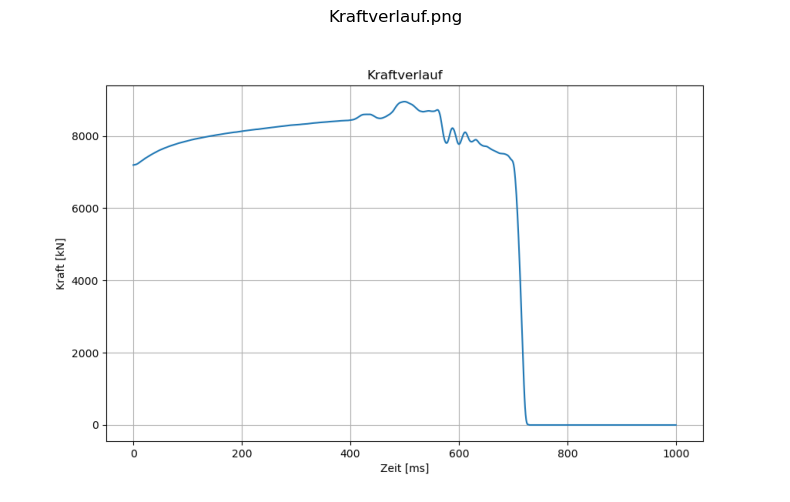

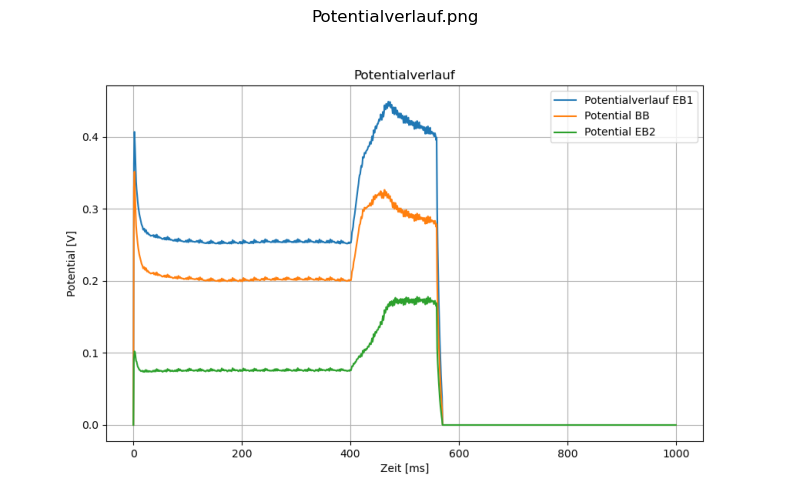

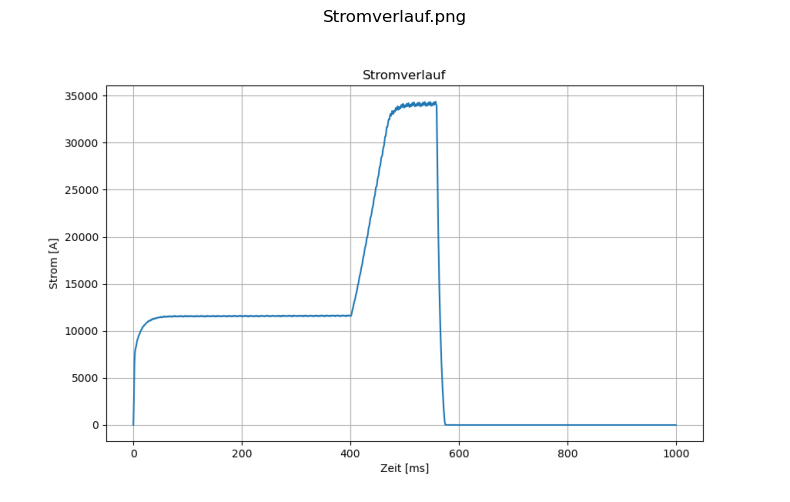

The job fortran_compile_job was saved and received the ID: 310


2025-07-25 07:44:42,073 - pyiron_log - WARNING - Job aborted - please remove it and run again! process_inp
2025-07-25 07:44:42,073 - pyiron_log - WARNING - Job aborted - please remove it and run again! process_inp


compiler output:
 
Intel(R) MPI Library 5.1 Update 2 for Windows* Target Build Environment for Intel(R) 64 applications
Copyright (C) 2007-2015 Intel Corporation. All rights reserved.

Copyright (C) 1985-2015 Intel Corporation. All rights reserved.
Intel(R) Compiler 16.0 Update 1 (package 146)
 

Microsoft (R) Incremental Linker Version 14.00.24215.1
Copyright (C) Microsoft Corporation.  All rights reserved.

-out:Testfall_1ms_modKInc_Dyn5_Abk7s_Auskommentiert.exe 
-subsystem:console 
Testfall_1ms_modKInc_Dyn5_Abk7s_Auskommentiert.obj 

 Intel(R) Visual Fortran Intel(R) 64 Compiler for applications running on Intel(R) 64, Version 16.0.1.146 Build 20151021
Copyright (C) 1985-2015 Intel Corporation.  All rights reserved.


Finish, generated file: ['Testfall_1ms_modKInc_Dyn5_Abk7s_Auskommentiert.exe']

The job process_inp was saved and received the ID: 311


2025-07-25 07:44:42,832 - pyiron_log - WARNING - Job aborted - please remove it and run again! run_exe
2025-07-25 07:44:42,832 - pyiron_log - WARNING - Job aborted - please remove it and run again! run_exe


finish, all files：['WPS_Elek_Contact.txt', 'WPS_Elek_Elemente.txt', 'WPS_MECH_MATERIAL_MECHANISCH.txt', 'WPS_MECH_Netz_Assembly.txt']

The job run_exe was saved and received the ID: 312
error：
STDOUT:
 
Intel(R) MPI Library 5.1 Update 2 for Windows* Target Build Environment for Intel(R) 64 applications
Copyright (C) 2007-2015 Intel Corporation. All rights reserved.

Copyright (C) 1985-2015 Intel Corporation. All rights reserved.
Intel(R) Compiler 16.0 Update 1 (package 146)
 

 Strom - Eingabedatei = ? (Stromverlauf.txt)

STDERR:
 forrtl: Die Pipe wurde beendet.

forrtl: severe (24): end-of-file during read, unit 5, file CONIN$
Image              PC                Routine            Line        Source             
Testfall_1ms_modK  00007FF6761A608B  Unknown               Unknown  Unknown
Testfall_1ms_modK  00007FF6761851E3  Unknown               Unknown  Unknown
Testfall_1ms_modK  00007FF67615114A  Unknown               Unknown  Unknown
Testfall_1ms_modK  00007FF6761F583E  Unknown    

FailedChildError: /Simulation_Workflow encountered error in child: {'/Simulation_Workflow/run_exe.accumulate_and_run': CalledProcessError(24, 'cmd /c "call "C:\\Program Files (x86)\\IntelSWTools\\compilers_and_libraries_2016.1.146\\windows\\bin\\ipsxe-comp-vars.bat" intel64 vs2015 && cd /d "C:/Local_Dong/Projekt/AnAttAl/CAD/AnAttAl_CAD_Aufbau_demo/run_exe_hdf5/run_exe" && "Testfall_1ms_modKInc_Dyn5_Abk7s_Auskommentiert.exe""')}

In [173]:
if __name__ == '__main__':
    
    wf = Workflow("Simulation_Workflow")

    # create project directory
    project_path = r'C:\Local_Dong\Projekt\AnAttAl\CAD\AnAttAl_CAD_Aufbau_demo'
    pr = Project(project_path)

    # Add the script and needed data directory
    plot_input_txts = [r"C:\Local_Dong\Projekt\AnAttAl\CAD\Stromverlauf.txt",
                       r"C:\Local_Dong\Projekt\AnAttAl\CAD\Kraftverlauf.txt",
                       r"C:\Local_Dong\Projekt\AnAttAl\CAD\Potentialverlauf.txt"]
    plot_script = r'C:\Local_Dong\Projekt\AnAttAl\CAD\txt_plot.py'
    abaqus_script = r'C:\Local_Dong\Projekt\AnAttAl\CAD\abaqusMacros.py'
    inp_to_txt_script = r'C:\Local_Dong\Projekt\AnAttAl\CAD\File_Programm3_mK.py'
    compiler_path = r'C:\Local_Dong\Projekt\AnAttAl\Simulations_Prozess\Compiler 16.0 Update 1 for Intel 64 Visual Studio 2015 environment.lnk'
    fortran_path = r'C:\Local_Dong\Projekt\AnAttAl\Simulations_Prozess\Testfall_1ms_modKInc_Dyn5_Abk7s_Auskommentiert.for'

    # 1.Plotting 3 txt files as pngs, check for data anomalies
    wf.plot_result = plot_txt_data(pr, plot_script, plot_input_txts)

    # 2.Open abaqus and run the script to extract the model's .inp file.
    wf.inp_data = export_inp_cae(pr, abaqus_script) 

    # 3.Convert the .inp file obtained in step 2. to a .txt file through the script.
    wf.txt_files = process_inp(pr, wf.inp_data["inp_path"], inp_to_txt_script)

    # 4.Open the fortran compiler on the command line and run the .for file to generate the .exe file
    wf.compiler_to_exe = compile_and_run_fortran(pr, compiler_path, fortran_path)

    # 5.Based on the .exe file from step 4., re-run it in the fortran compiler with the 7 txt files required
    wf.run_exe = run_exe(pr, compiler_path, 
                         wf.compiler_to_exe["exe_path"],
                         txt_from_inp=wf.txt_files,
                         txt_from_plot=plot_input_txts)

    # .......

    wf.run()